/opt/conda/lib/python3.11/site-packages/kornia/feature/lightglue.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


BeamSystem Visualization Test
Device: cuda

Grid size: 256
Zernike modes: 15
Action scale: 2.0
Aberration scale: 2.0

=== Before Correction ===
PSNR: 34.10 dB
Strehl: 1.0000

=== After Optimal Correction ===
PSNR: 152.79 dB
Strehl: 1.0000
PSNR Improvement: 118.69 dB


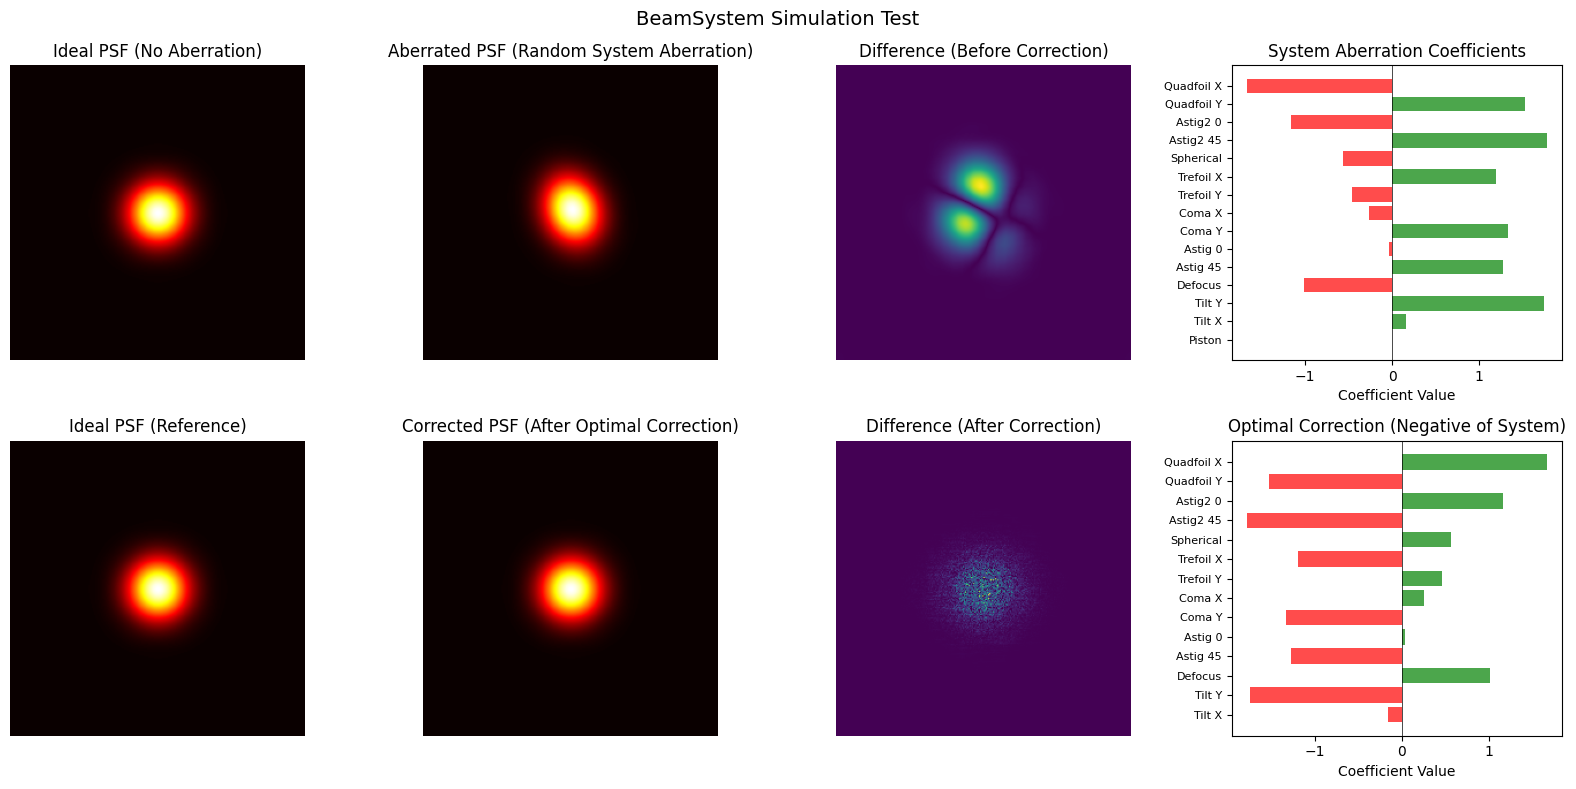


Progressive Correction Test


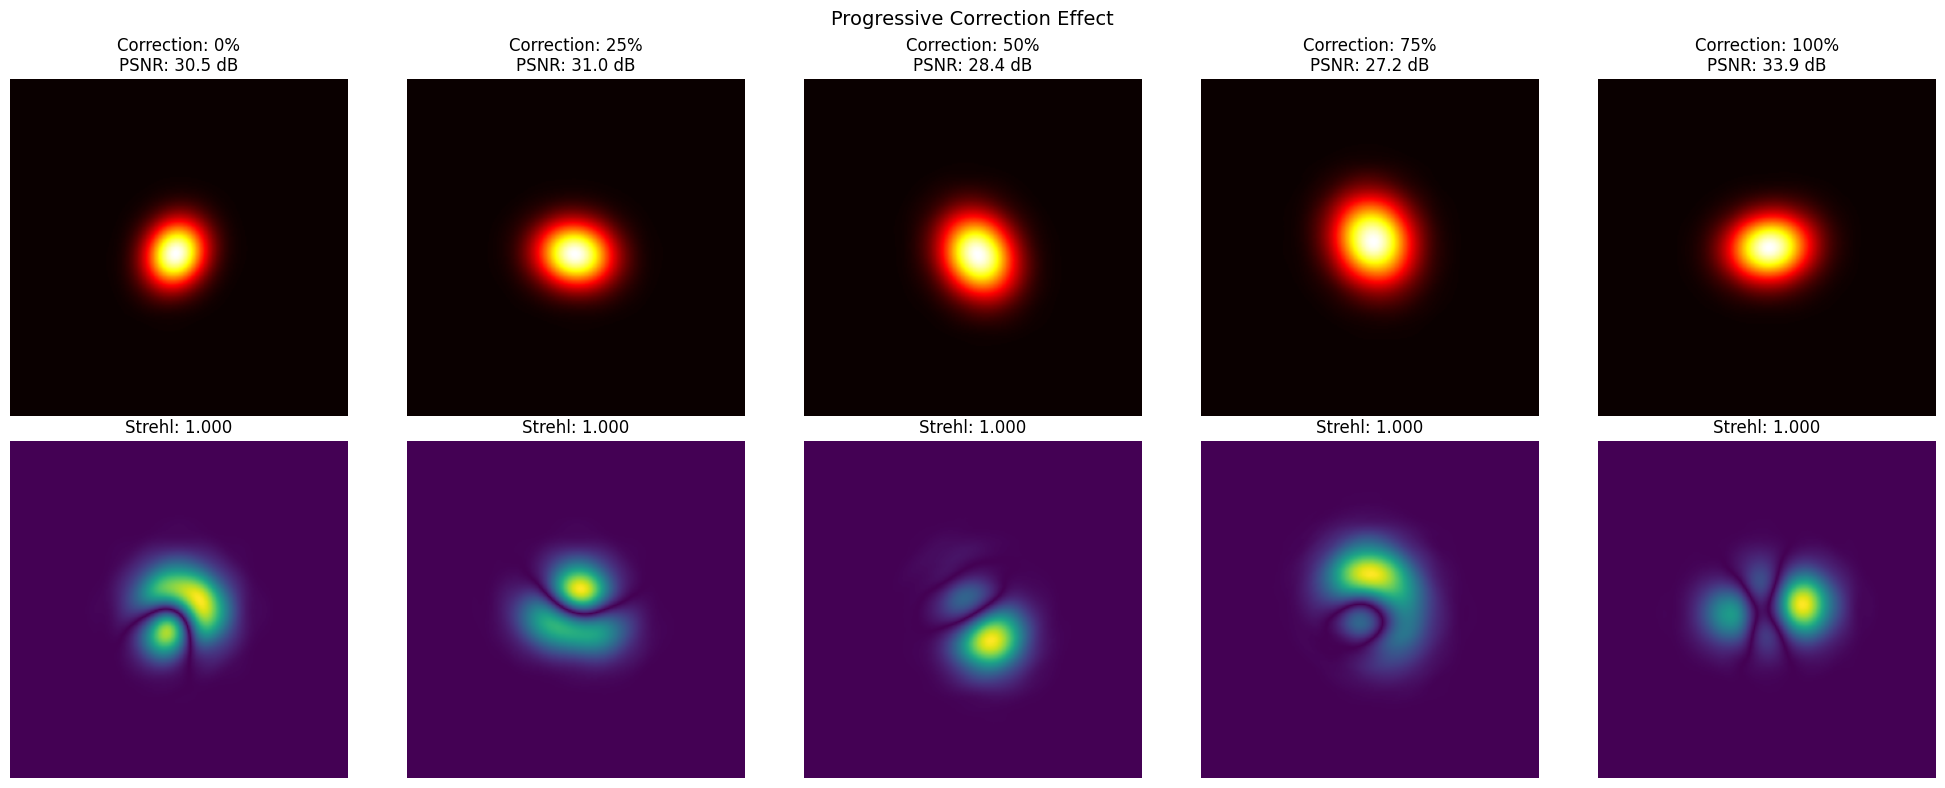

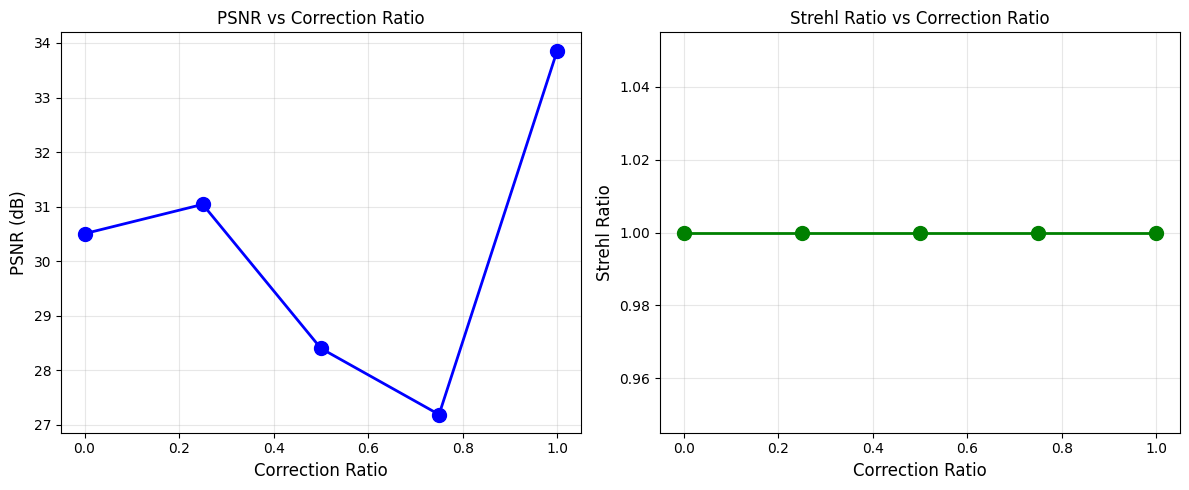


Test Complete!

PSNR values: [30.50443458557129, 31.04149627685547, 28.401744842529297, 27.189245223999023, 33.86146926879883]
Strehl values: [1.0, 1.0, 1.0, 1.0, 1.0]


In [1]:
"""
BeamSystem 시각화 테스트
- 시스템 수차 적용 확인
- 보정 효과 확인
- PSNR 변화 확인
"""

import torch
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

try:
    base_dir = os.path.dirname(__file__)
except NameError:
    base_dir = os.getcwd()

sys.path.append(os.path.abspath(os.path.join(base_dir, '..')))

from zoo.beam_system import BeamSystem

zernike_scale = 2.0

def test_visualization():
    """BeamSystem 시각화 테스트"""
    print("=" * 60)
    print("BeamSystem Visualization Test")
    print("=" * 60)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}")
    
    # BeamSystem 생성
    system = BeamSystem(
        grid_size=256,
        pixel_size=6.3e-6,
        wavelength=638e-9,
        laser_to_slm_distance=0.05,
        slm_to_camera_distance=0.05,
        max_zernike_modes=15,
        action_scale=zernike_scale,        # 액션 범위 [-5, +5]
        aberration_scale=zernike_scale,    # 시스템 수차 범위 [-5, +5]
        device=device
    )
    
    print(f"\nGrid size: {system.grid_size}")
    print(f"Zernike modes: {system.max_zernike_modes}")
    print(f"Action scale: {system.action_scale}")
    print(f"Aberration scale: {system.aberration_scale}")
    
    # === 1. 이상적 PSF vs 수차 PSF 비교 ===
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('BeamSystem Simulation Test', fontsize=14)
    
    # 이상적 PSF
    ideal_psf = system.ideal_psf.cpu().numpy()
    axes[0, 0].imshow(ideal_psf, cmap='hot')
    axes[0, 0].set_title('Ideal PSF (No Aberration)')
    axes[0, 0].axis('off')
    
    # 수차 적용 PSF
    batch_size = 1
    aberrated_psf = system.reset(batch_size=batch_size)
    aberrated_np = aberrated_psf[0, 0].cpu().numpy()
    
    axes[0, 1].imshow(aberrated_np, cmap='hot')
    axes[0, 1].set_title('Aberrated PSF (Random System Aberration)')
    axes[0, 1].axis('off')
    
    # 차이
    diff_before = np.abs(aberrated_np - ideal_psf)
    axes[0, 2].imshow(diff_before, cmap='viridis')
    axes[0, 2].set_title('Difference (Before Correction)')
    axes[0, 2].axis('off')
    
    # 시스템 수차 계수 시각화
    sys_coeffs = system.system_aberration[0].cpu().numpy()
    zernike_names = ['Piston', 'Tilt X', 'Tilt Y', 'Defocus', 'Astig 45', 'Astig 0',
                     'Coma Y', 'Coma X', 'Trefoil Y', 'Trefoil X', 'Spherical',
                     'Astig2 45', 'Astig2 0', 'Quadfoil Y', 'Quadfoil X']
    colors = ['green' if c >= 0 else 'red' for c in sys_coeffs]
    axes[0, 3].barh(range(len(sys_coeffs)), sys_coeffs, color=colors, alpha=0.7)
    axes[0, 3].set_yticks(range(len(sys_coeffs)))
    axes[0, 3].set_yticklabels(zernike_names[:len(sys_coeffs)], fontsize=8)
    axes[0, 3].set_xlabel('Coefficient Value')
    axes[0, 3].set_title('System Aberration Coefficients')
    axes[0, 3].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # 초기 메트릭
    metrics_before = system.compute_metrics(aberrated_psf)
    print(f"\n=== Before Correction ===")
    print(f"PSNR: {metrics_before['psnr']:.2f} dB")
    print(f"Strehl: {metrics_before['strehl']:.4f}")
    
    # === 2. 보정 적용 ===
    # 최적 보정 (시스템 수차의 음수)
    optimal_correction = system.get_optimal_correction()  # (batch, zernike-1)
    corrected_psf = system.forward(optimal_correction / system.action_scale)
    corrected_np = corrected_psf[0, 0].cpu().numpy()
    
    axes[1, 0].imshow(ideal_psf, cmap='hot')
    axes[1, 0].set_title('Ideal PSF (Reference)')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(corrected_np, cmap='hot')
    axes[1, 1].set_title('Corrected PSF (After Optimal Correction)')
    axes[1, 1].axis('off')
    
    # 차이
    diff_after = np.abs(corrected_np - ideal_psf)
    axes[1, 2].imshow(diff_after, cmap='viridis')
    axes[1, 2].set_title('Difference (After Correction)')
    axes[1, 2].axis('off')
    
    # 보정 계수 시각화
    corr_coeffs = optimal_correction[0].cpu().numpy()
    # Z0 제외이므로 인덱스 조정
    colors = ['green' if c >= 0 else 'red' for c in corr_coeffs]
    axes[1, 3].barh(range(len(corr_coeffs)), corr_coeffs, color=colors, alpha=0.7)
    axes[1, 3].set_yticks(range(len(corr_coeffs)))
    axes[1, 3].set_yticklabels(zernike_names[1:len(corr_coeffs)+1], fontsize=8)
    axes[1, 3].set_xlabel('Coefficient Value')
    axes[1, 3].set_title('Optimal Correction (Negative of System)')
    axes[1, 3].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # 보정 후 메트릭
    metrics_after = system.compute_metrics(corrected_psf)
    print(f"\n=== After Optimal Correction ===")
    print(f"PSNR: {metrics_after['psnr']:.2f} dB")
    print(f"Strehl: {metrics_after['strehl']:.4f}")
    print(f"PSNR Improvement: {metrics_after['psnr'] - metrics_before['psnr']:.2f} dB")
    
    plt.tight_layout()
    plt.savefig('beam_system_test.png', dpi=150)
    plt.show()
    
    # === 3. 점진적 보정 테스트 ===
    print("\n" + "=" * 60)
    print("Progressive Correction Test")
    print("=" * 60)
    
    fig2, axes2 = plt.subplots(2, 5, figsize=(20, 8))
    fig2.suptitle('Progressive Correction Effect', fontsize=14)
    
    # 새로운 에피소드
    aberrated_psf = system.reset(batch_size=1)
    optimal_correction = system.get_optimal_correction()
    
    correction_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]
    psnr_values = []
    strehl_values = []
    
    for i, ratio in enumerate(correction_ratios):
        # 부분 보정 적용
        partial_correction = optimal_correction * ratio
        
        if ratio == 0.0:
            psf = aberrated_psf
        else:
            # 리셋 후 부분 보정
            _ = system.reset(batch_size=1)
            system.system_aberration = system.system_aberration  # 같은 수차 유지
            psf = system.forward(partial_correction / system.action_scale)
        
        psf_np = psf[0, 0].cpu().numpy()
        metrics = system.compute_metrics(psf)
        psnr_values.append(metrics['psnr'])
        strehl_values.append(metrics['strehl'])
        
        # 상단: PSF
        axes2[0, i].imshow(psf_np, cmap='hot')
        axes2[0, i].set_title(f'Correction: {int(ratio*100)}%\nPSNR: {metrics["psnr"]:.1f} dB')
        axes2[0, i].axis('off')
        
        # 하단: 차이
        diff = np.abs(psf_np - ideal_psf)
        axes2[1, i].imshow(diff, cmap='viridis')
        axes2[1, i].set_title(f'Strehl: {metrics["strehl"]:.3f}')
        axes2[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('beam_system_progressive.png', dpi=150)
    plt.show()
    
    # PSNR/Strehl 변화 그래프
    fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(correction_ratios, psnr_values, 'bo-', linewidth=2, markersize=10)
    ax1.set_xlabel('Correction Ratio', fontsize=12)
    ax1.set_ylabel('PSNR (dB)', fontsize=12)
    ax1.set_title('PSNR vs Correction Ratio')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(correction_ratios, strehl_values, 'go-', linewidth=2, markersize=10)
    ax2.set_xlabel('Correction Ratio', fontsize=12)
    ax2.set_ylabel('Strehl Ratio', fontsize=12)
    ax2.set_title('Strehl Ratio vs Correction Ratio')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('beam_system_metrics.png', dpi=150)
    plt.show()
    
    print("\n" + "=" * 60)
    print("Test Complete!")
    print("=" * 60)
    print(f"\nPSNR values: {psnr_values}")
    print(f"Strehl values: {strehl_values}")


if __name__ == "__main__":
    test_visualization()


BeamSystem Visualization Test
Device: cuda

Grid size: 256
Zernike modes: 15
Action scale: 5.0
Aberration scale: 5.0

=== Before Correction ===
PSNR: 23.52 dB
Strehl: 1.0000

=== After Optimal Correction ===
PSNR: 153.29 dB
Strehl: 1.0000
PSNR Improvement: 129.77 dB


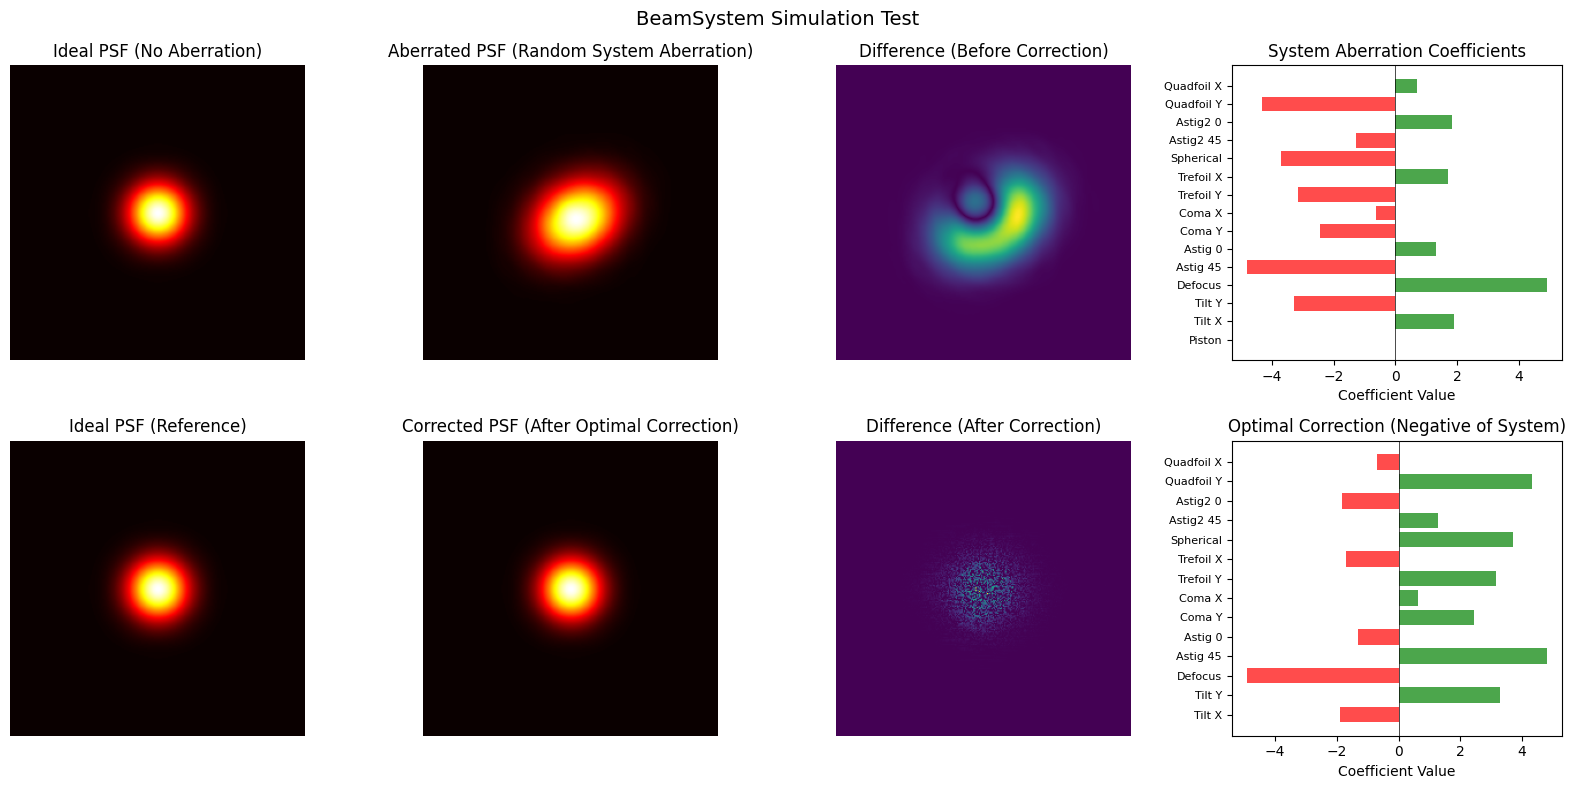


Progressive Correction Test


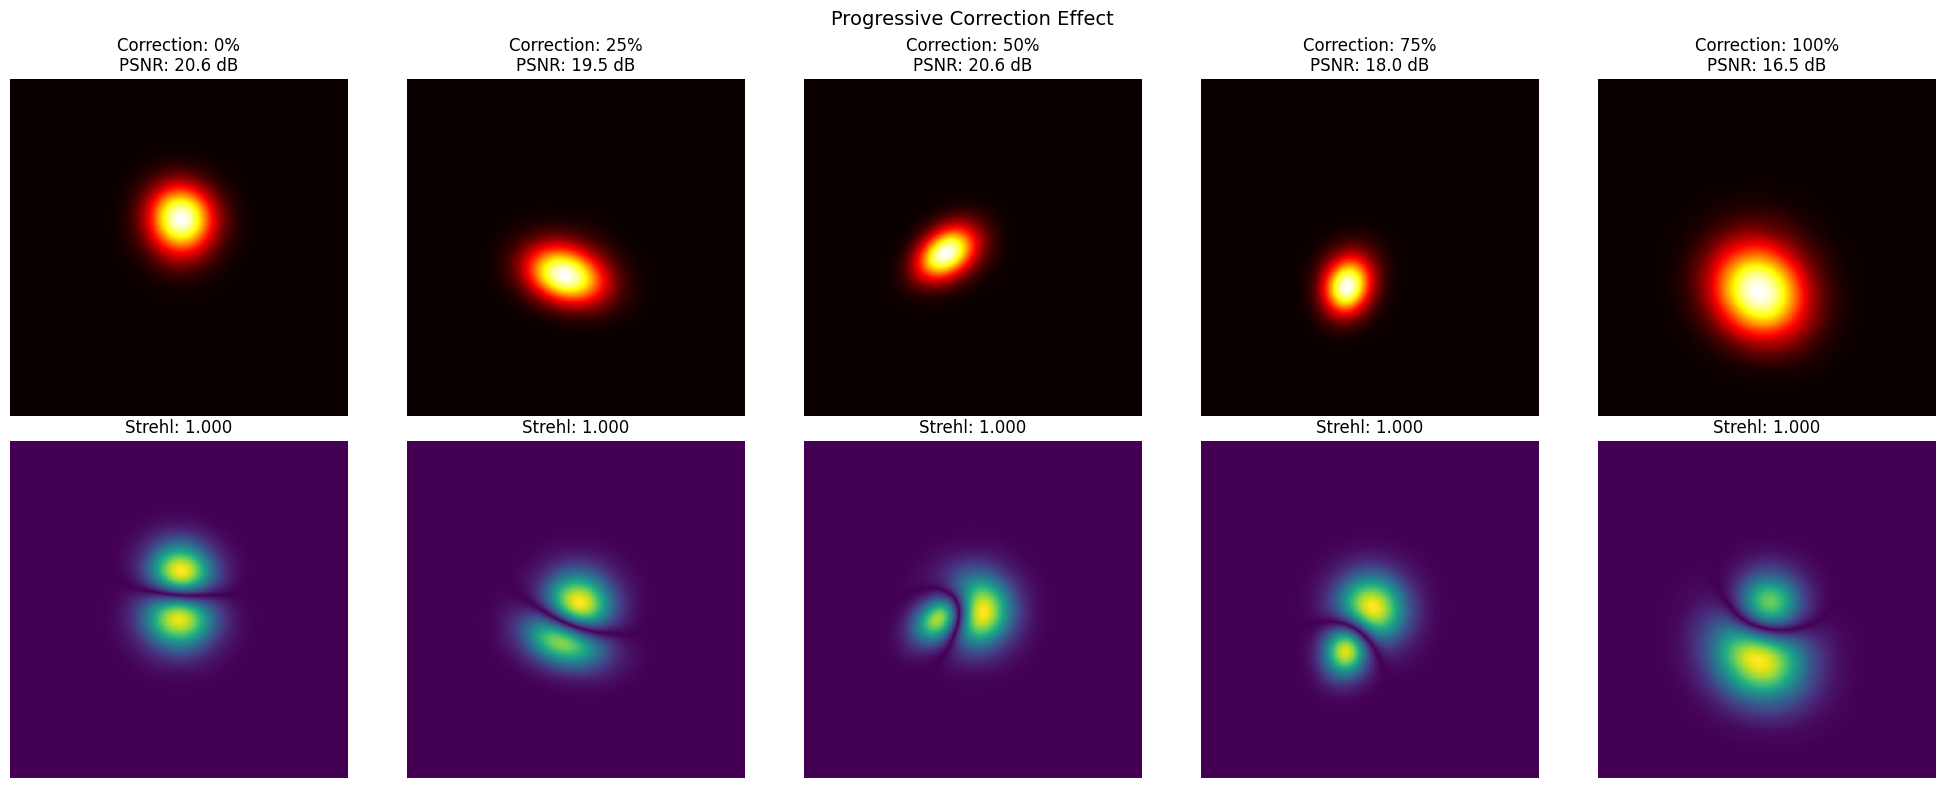

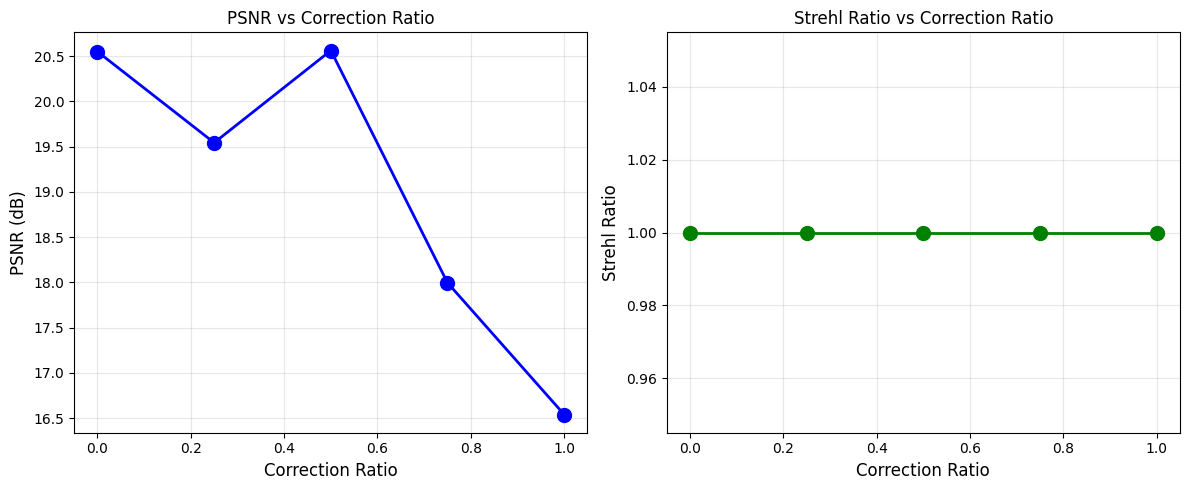


Test Complete!

PSNR values: [20.55077362060547, 19.544164657592773, 20.562969207763672, 17.996562957763672, 16.540206909179688]
Strehl values: [1.0, 1.0, 1.0, 1.0, 1.0]


In [2]:
"""
BeamSystem 시각화 테스트
- 시스템 수차 적용 확인
- 보정 효과 확인
- PSNR 변화 확인
"""

import torch
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

try:
    base_dir = os.path.dirname(__file__)
except NameError:
    base_dir = os.getcwd()

sys.path.append(os.path.abspath(os.path.join(base_dir, '..')))

from zoo.beam_system import BeamSystem

zernike_scale = 5.0

def test_visualization():
    """BeamSystem 시각화 테스트"""
    print("=" * 60)
    print("BeamSystem Visualization Test")
    print("=" * 60)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}")
    
    # BeamSystem 생성
    system = BeamSystem(
        grid_size=256,
        pixel_size=6.3e-6,
        wavelength=638e-9,
        laser_to_slm_distance=0.05,
        slm_to_camera_distance=0.05,
        max_zernike_modes=15,
        action_scale=zernike_scale,        # 액션 범위 [-5, +5]
        aberration_scale=zernike_scale,    # 시스템 수차 범위 [-5, +5]
        device=device
    )
    
    print(f"\nGrid size: {system.grid_size}")
    print(f"Zernike modes: {system.max_zernike_modes}")
    print(f"Action scale: {system.action_scale}")
    print(f"Aberration scale: {system.aberration_scale}")
    
    # === 1. 이상적 PSF vs 수차 PSF 비교 ===
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('BeamSystem Simulation Test', fontsize=14)
    
    # 이상적 PSF
    ideal_psf = system.ideal_psf.cpu().numpy()
    axes[0, 0].imshow(ideal_psf, cmap='hot')
    axes[0, 0].set_title('Ideal PSF (No Aberration)')
    axes[0, 0].axis('off')
    
    # 수차 적용 PSF
    batch_size = 1
    aberrated_psf = system.reset(batch_size=batch_size)
    aberrated_np = aberrated_psf[0, 0].cpu().numpy()
    
    axes[0, 1].imshow(aberrated_np, cmap='hot')
    axes[0, 1].set_title('Aberrated PSF (Random System Aberration)')
    axes[0, 1].axis('off')
    
    # 차이
    diff_before = np.abs(aberrated_np - ideal_psf)
    axes[0, 2].imshow(diff_before, cmap='viridis')
    axes[0, 2].set_title('Difference (Before Correction)')
    axes[0, 2].axis('off')
    
    # 시스템 수차 계수 시각화
    sys_coeffs = system.system_aberration[0].cpu().numpy()
    zernike_names = ['Piston', 'Tilt X', 'Tilt Y', 'Defocus', 'Astig 45', 'Astig 0',
                     'Coma Y', 'Coma X', 'Trefoil Y', 'Trefoil X', 'Spherical',
                     'Astig2 45', 'Astig2 0', 'Quadfoil Y', 'Quadfoil X']
    colors = ['green' if c >= 0 else 'red' for c in sys_coeffs]
    axes[0, 3].barh(range(len(sys_coeffs)), sys_coeffs, color=colors, alpha=0.7)
    axes[0, 3].set_yticks(range(len(sys_coeffs)))
    axes[0, 3].set_yticklabels(zernike_names[:len(sys_coeffs)], fontsize=8)
    axes[0, 3].set_xlabel('Coefficient Value')
    axes[0, 3].set_title('System Aberration Coefficients')
    axes[0, 3].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # 초기 메트릭
    metrics_before = system.compute_metrics(aberrated_psf)
    print(f"\n=== Before Correction ===")
    print(f"PSNR: {metrics_before['psnr']:.2f} dB")
    print(f"Strehl: {metrics_before['strehl']:.4f}")
    
    # === 2. 보정 적용 ===
    # 최적 보정 (시스템 수차의 음수)
    optimal_correction = system.get_optimal_correction()  # (batch, zernike-1)
    corrected_psf = system.forward(optimal_correction / system.action_scale)
    corrected_np = corrected_psf[0, 0].cpu().numpy()
    
    axes[1, 0].imshow(ideal_psf, cmap='hot')
    axes[1, 0].set_title('Ideal PSF (Reference)')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(corrected_np, cmap='hot')
    axes[1, 1].set_title('Corrected PSF (After Optimal Correction)')
    axes[1, 1].axis('off')
    
    # 차이
    diff_after = np.abs(corrected_np - ideal_psf)
    axes[1, 2].imshow(diff_after, cmap='viridis')
    axes[1, 2].set_title('Difference (After Correction)')
    axes[1, 2].axis('off')
    
    # 보정 계수 시각화
    corr_coeffs = optimal_correction[0].cpu().numpy()
    # Z0 제외이므로 인덱스 조정
    colors = ['green' if c >= 0 else 'red' for c in corr_coeffs]
    axes[1, 3].barh(range(len(corr_coeffs)), corr_coeffs, color=colors, alpha=0.7)
    axes[1, 3].set_yticks(range(len(corr_coeffs)))
    axes[1, 3].set_yticklabels(zernike_names[1:len(corr_coeffs)+1], fontsize=8)
    axes[1, 3].set_xlabel('Coefficient Value')
    axes[1, 3].set_title('Optimal Correction (Negative of System)')
    axes[1, 3].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # 보정 후 메트릭
    metrics_after = system.compute_metrics(corrected_psf)
    print(f"\n=== After Optimal Correction ===")
    print(f"PSNR: {metrics_after['psnr']:.2f} dB")
    print(f"Strehl: {metrics_after['strehl']:.4f}")
    print(f"PSNR Improvement: {metrics_after['psnr'] - metrics_before['psnr']:.2f} dB")
    
    plt.tight_layout()
    plt.savefig('beam_system_test.png', dpi=150)
    plt.show()
    
    # === 3. 점진적 보정 테스트 ===
    print("\n" + "=" * 60)
    print("Progressive Correction Test")
    print("=" * 60)
    
    fig2, axes2 = plt.subplots(2, 5, figsize=(20, 8))
    fig2.suptitle('Progressive Correction Effect', fontsize=14)
    
    # 새로운 에피소드
    aberrated_psf = system.reset(batch_size=1)
    optimal_correction = system.get_optimal_correction()
    
    correction_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]
    psnr_values = []
    strehl_values = []
    
    for i, ratio in enumerate(correction_ratios):
        # 부분 보정 적용
        partial_correction = optimal_correction * ratio
        
        if ratio == 0.0:
            psf = aberrated_psf
        else:
            # 리셋 후 부분 보정
            _ = system.reset(batch_size=1)
            system.system_aberration = system.system_aberration  # 같은 수차 유지
            psf = system.forward(partial_correction / system.action_scale)
        
        psf_np = psf[0, 0].cpu().numpy()
        metrics = system.compute_metrics(psf)
        psnr_values.append(metrics['psnr'])
        strehl_values.append(metrics['strehl'])
        
        # 상단: PSF
        axes2[0, i].imshow(psf_np, cmap='hot')
        axes2[0, i].set_title(f'Correction: {int(ratio*100)}%\nPSNR: {metrics["psnr"]:.1f} dB')
        axes2[0, i].axis('off')
        
        # 하단: 차이
        diff = np.abs(psf_np - ideal_psf)
        axes2[1, i].imshow(diff, cmap='viridis')
        axes2[1, i].set_title(f'Strehl: {metrics["strehl"]:.3f}')
        axes2[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('beam_system_progressive.png', dpi=150)
    plt.show()
    
    # PSNR/Strehl 변화 그래프
    fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(correction_ratios, psnr_values, 'bo-', linewidth=2, markersize=10)
    ax1.set_xlabel('Correction Ratio', fontsize=12)
    ax1.set_ylabel('PSNR (dB)', fontsize=12)
    ax1.set_title('PSNR vs Correction Ratio')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(correction_ratios, strehl_values, 'go-', linewidth=2, markersize=10)
    ax2.set_xlabel('Correction Ratio', fontsize=12)
    ax2.set_ylabel('Strehl Ratio', fontsize=12)
    ax2.set_title('Strehl Ratio vs Correction Ratio')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('beam_system_metrics.png', dpi=150)
    plt.show()
    
    print("\n" + "=" * 60)
    print("Test Complete!")
    print("=" * 60)
    print(f"\nPSNR values: {psnr_values}")
    print(f"Strehl values: {strehl_values}")


if __name__ == "__main__":
    test_visualization()


BeamSystem Visualization Test
Device: cuda

Grid size: 256
Zernike modes: 15
Action scale: 20.0
Aberration scale: 20.0

=== Before Correction ===
PSNR: 17.16 dB
Strehl: 1.0000

=== After Optimal Correction ===
PSNR: 147.60 dB
Strehl: 1.0000
PSNR Improvement: 130.45 dB


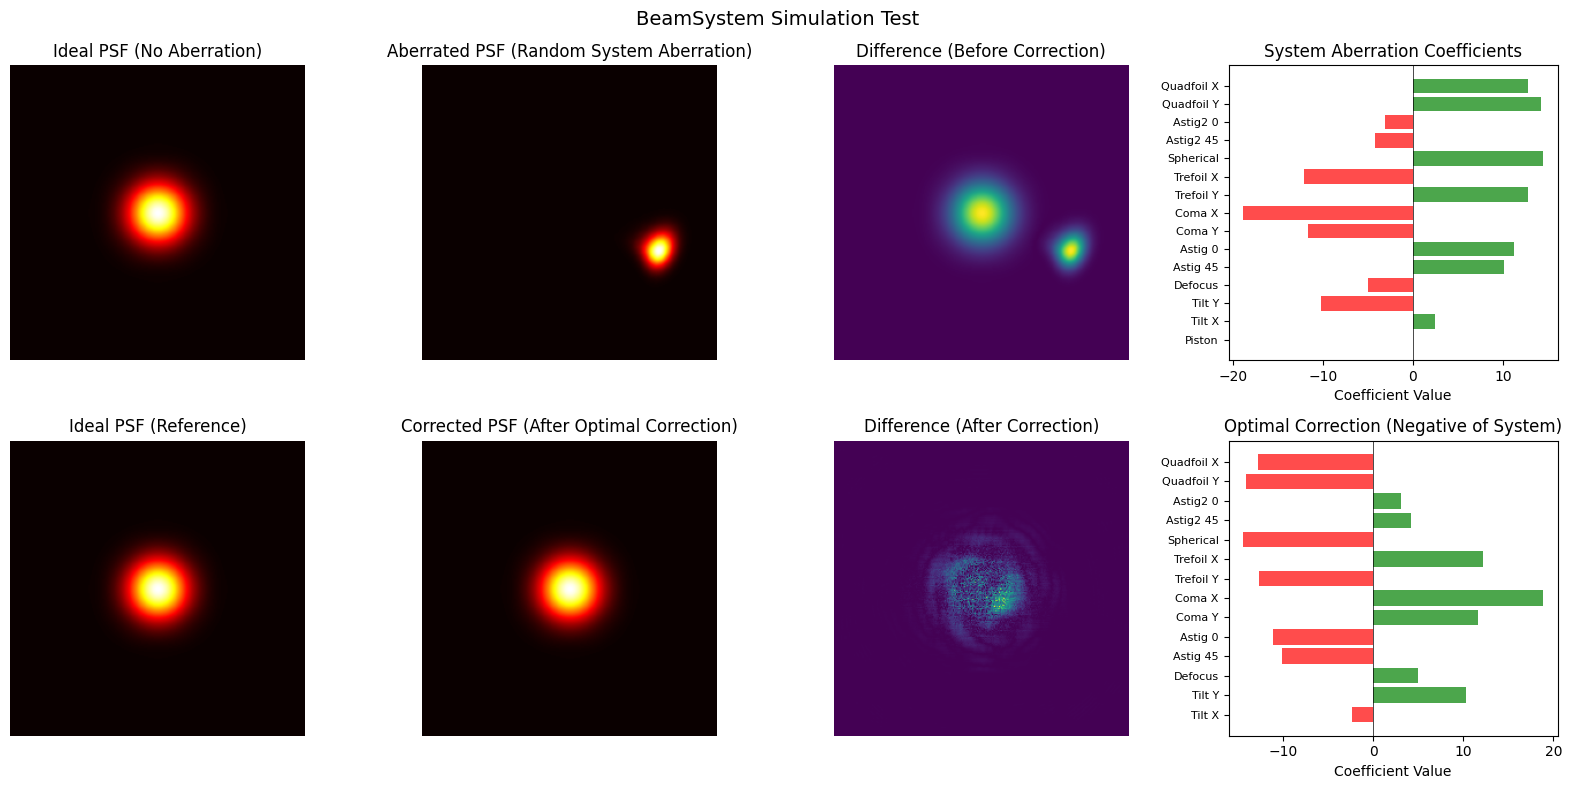


Progressive Correction Test


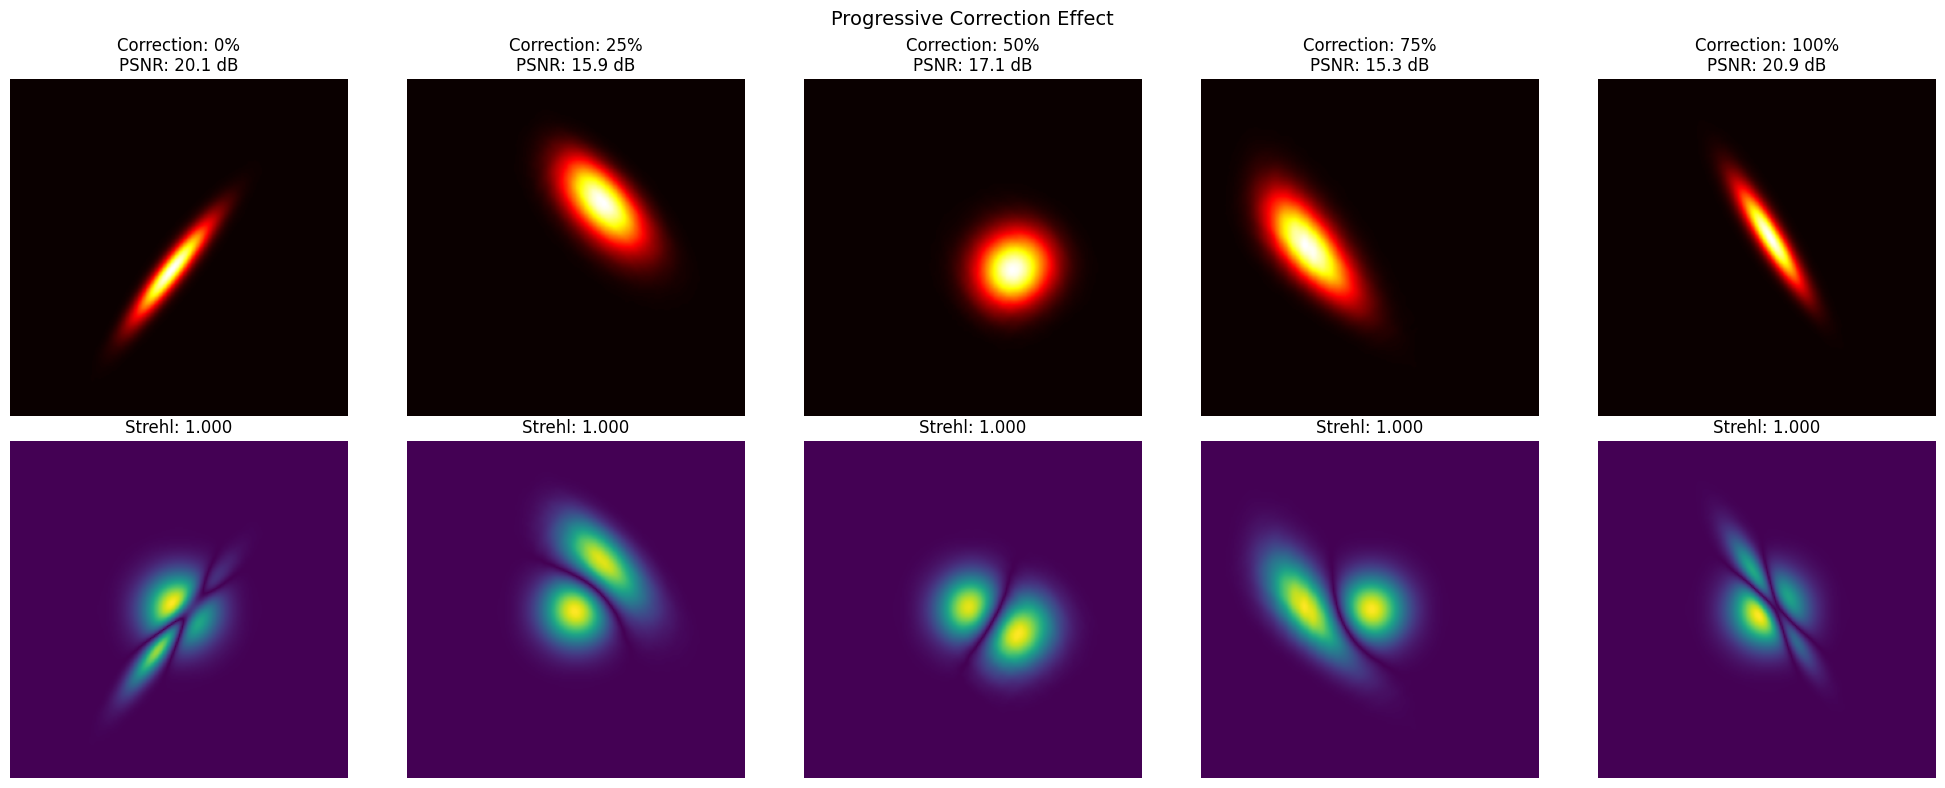

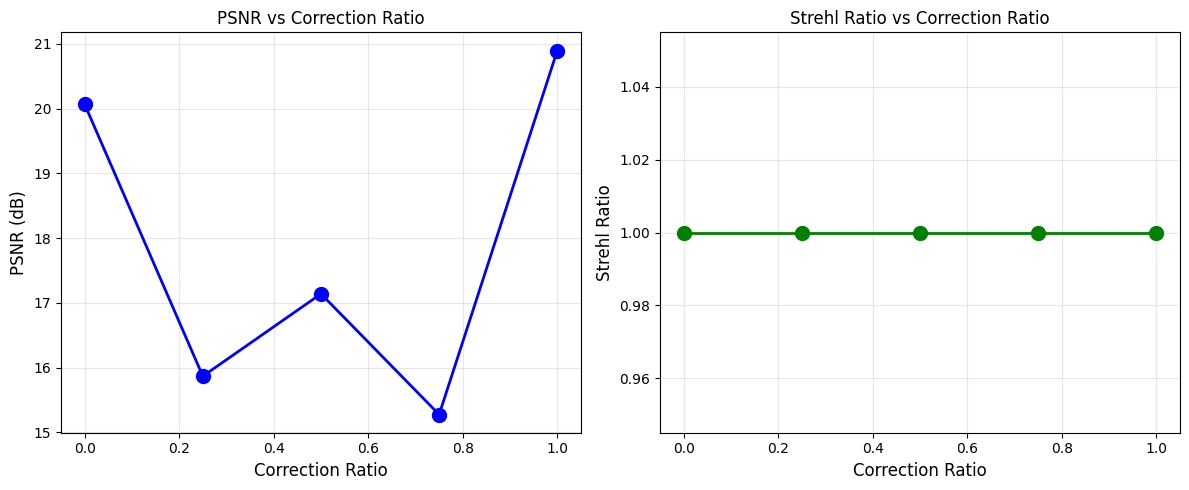


Test Complete!

PSNR values: [20.067413330078125, 15.866793632507324, 17.139204025268555, 15.274821281433105, 20.89776039123535]
Strehl values: [1.0, 1.0, 1.0, 1.0, 1.0]


In [4]:
"""
BeamSystem 시각화 테스트
- 시스템 수차 적용 확인
- 보정 효과 확인
- PSNR 변화 확인
"""

import torch
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

try:
    base_dir = os.path.dirname(__file__)
except NameError:
    base_dir = os.getcwd()

sys.path.append(os.path.abspath(os.path.join(base_dir, '..')))

from zoo.beam_system import BeamSystem

zernike_scale = 20.0

def test_visualization():
    """BeamSystem 시각화 테스트"""
    print("=" * 60)
    print("BeamSystem Visualization Test")
    print("=" * 60)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}")
    
    # BeamSystem 생성
    system = BeamSystem(
        grid_size=256,
        pixel_size=6.3e-6,
        wavelength=638e-9,
        laser_to_slm_distance=0.05,
        slm_to_camera_distance=0.05,
        max_zernike_modes=15,
        action_scale=zernike_scale,        # 액션 범위 [-5, +5]
        aberration_scale=zernike_scale,    # 시스템 수차 범위 [-5, +5]
        device=device
    )
    
    print(f"\nGrid size: {system.grid_size}")
    print(f"Zernike modes: {system.max_zernike_modes}")
    print(f"Action scale: {system.action_scale}")
    print(f"Aberration scale: {system.aberration_scale}")
    
    # === 1. 이상적 PSF vs 수차 PSF 비교 ===
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('BeamSystem Simulation Test', fontsize=14)
    
    # 이상적 PSF
    ideal_psf = system.ideal_psf.cpu().numpy()
    axes[0, 0].imshow(ideal_psf, cmap='hot')
    axes[0, 0].set_title('Ideal PSF (No Aberration)')
    axes[0, 0].axis('off')
    
    # 수차 적용 PSF
    batch_size = 1
    aberrated_psf = system.reset(batch_size=batch_size)
    aberrated_np = aberrated_psf[0, 0].cpu().numpy()
    
    axes[0, 1].imshow(aberrated_np, cmap='hot')
    axes[0, 1].set_title('Aberrated PSF (Random System Aberration)')
    axes[0, 1].axis('off')
    
    # 차이
    diff_before = np.abs(aberrated_np - ideal_psf)
    axes[0, 2].imshow(diff_before, cmap='viridis')
    axes[0, 2].set_title('Difference (Before Correction)')
    axes[0, 2].axis('off')
    
    # 시스템 수차 계수 시각화
    sys_coeffs = system.system_aberration[0].cpu().numpy()
    zernike_names = ['Piston', 'Tilt X', 'Tilt Y', 'Defocus', 'Astig 45', 'Astig 0',
                     'Coma Y', 'Coma X', 'Trefoil Y', 'Trefoil X', 'Spherical',
                     'Astig2 45', 'Astig2 0', 'Quadfoil Y', 'Quadfoil X']
    colors = ['green' if c >= 0 else 'red' for c in sys_coeffs]
    axes[0, 3].barh(range(len(sys_coeffs)), sys_coeffs, color=colors, alpha=0.7)
    axes[0, 3].set_yticks(range(len(sys_coeffs)))
    axes[0, 3].set_yticklabels(zernike_names[:len(sys_coeffs)], fontsize=8)
    axes[0, 3].set_xlabel('Coefficient Value')
    axes[0, 3].set_title('System Aberration Coefficients')
    axes[0, 3].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # 초기 메트릭
    metrics_before = system.compute_metrics(aberrated_psf)
    print(f"\n=== Before Correction ===")
    print(f"PSNR: {metrics_before['psnr']:.2f} dB")
    print(f"Strehl: {metrics_before['strehl']:.4f}")
    
    # === 2. 보정 적용 ===
    # 최적 보정 (시스템 수차의 음수)
    optimal_correction = system.get_optimal_correction()  # (batch, zernike-1)
    corrected_psf = system.forward(optimal_correction / system.action_scale)
    corrected_np = corrected_psf[0, 0].cpu().numpy()
    
    axes[1, 0].imshow(ideal_psf, cmap='hot')
    axes[1, 0].set_title('Ideal PSF (Reference)')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(corrected_np, cmap='hot')
    axes[1, 1].set_title('Corrected PSF (After Optimal Correction)')
    axes[1, 1].axis('off')
    
    # 차이
    diff_after = np.abs(corrected_np - ideal_psf)
    axes[1, 2].imshow(diff_after, cmap='viridis')
    axes[1, 2].set_title('Difference (After Correction)')
    axes[1, 2].axis('off')
    
    # 보정 계수 시각화
    corr_coeffs = optimal_correction[0].cpu().numpy()
    # Z0 제외이므로 인덱스 조정
    colors = ['green' if c >= 0 else 'red' for c in corr_coeffs]
    axes[1, 3].barh(range(len(corr_coeffs)), corr_coeffs, color=colors, alpha=0.7)
    axes[1, 3].set_yticks(range(len(corr_coeffs)))
    axes[1, 3].set_yticklabels(zernike_names[1:len(corr_coeffs)+1], fontsize=8)
    axes[1, 3].set_xlabel('Coefficient Value')
    axes[1, 3].set_title('Optimal Correction (Negative of System)')
    axes[1, 3].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # 보정 후 메트릭
    metrics_after = system.compute_metrics(corrected_psf)
    print(f"\n=== After Optimal Correction ===")
    print(f"PSNR: {metrics_after['psnr']:.2f} dB")
    print(f"Strehl: {metrics_after['strehl']:.4f}")
    print(f"PSNR Improvement: {metrics_after['psnr'] - metrics_before['psnr']:.2f} dB")
    
    plt.tight_layout()
    plt.savefig('beam_system_test.png', dpi=150)
    plt.show()
    
    # === 3. 점진적 보정 테스트 ===
    print("\n" + "=" * 60)
    print("Progressive Correction Test")
    print("=" * 60)
    
    fig2, axes2 = plt.subplots(2, 5, figsize=(20, 8))
    fig2.suptitle('Progressive Correction Effect', fontsize=14)
    
    # 새로운 에피소드
    aberrated_psf = system.reset(batch_size=1)
    optimal_correction = system.get_optimal_correction()
    
    correction_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]
    psnr_values = []
    strehl_values = []
    
    for i, ratio in enumerate(correction_ratios):
        # 부분 보정 적용
        partial_correction = optimal_correction * ratio
        
        if ratio == 0.0:
            psf = aberrated_psf
        else:
            # 리셋 후 부분 보정
            _ = system.reset(batch_size=1)
            system.system_aberration = system.system_aberration  # 같은 수차 유지
            psf = system.forward(partial_correction / system.action_scale)
        
        psf_np = psf[0, 0].cpu().numpy()
        metrics = system.compute_metrics(psf)
        psnr_values.append(metrics['psnr'])
        strehl_values.append(metrics['strehl'])
        
        # 상단: PSF
        axes2[0, i].imshow(psf_np, cmap='hot')
        axes2[0, i].set_title(f'Correction: {int(ratio*100)}%\nPSNR: {metrics["psnr"]:.1f} dB')
        axes2[0, i].axis('off')
        
        # 하단: 차이
        diff = np.abs(psf_np - ideal_psf)
        axes2[1, i].imshow(diff, cmap='viridis')
        axes2[1, i].set_title(f'Strehl: {metrics["strehl"]:.3f}')
        axes2[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('beam_system_progressive.png', dpi=150)
    plt.show()
    
    # PSNR/Strehl 변화 그래프
    fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(correction_ratios, psnr_values, 'bo-', linewidth=2, markersize=10)
    ax1.set_xlabel('Correction Ratio', fontsize=12)
    ax1.set_ylabel('PSNR (dB)', fontsize=12)
    ax1.set_title('PSNR vs Correction Ratio')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(correction_ratios, strehl_values, 'go-', linewidth=2, markersize=10)
    ax2.set_xlabel('Correction Ratio', fontsize=12)
    ax2.set_ylabel('Strehl Ratio', fontsize=12)
    ax2.set_title('Strehl Ratio vs Correction Ratio')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('beam_system_metrics.png', dpi=150)
    plt.show()
    
    print("\n" + "=" * 60)
    print("Test Complete!")
    print("=" * 60)
    print(f"\nPSNR values: {psnr_values}")
    print(f"Strehl values: {strehl_values}")


if __name__ == "__main__":
    test_visualization()
